In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../../..'))

from importlib import reload
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.incarceration_transitions import IncarceratedTransitions


In [2]:
test_sim = SuperSimulationFactory.build_super_simulation('../../state/IL/IL_prison_RMM_model_inputs.yaml')
# test_sim.simulate_baseline('pretrial', 'prison')

/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1728: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 1080 results
transitions_data returned 478 results
total_population_data returned 1080 results


initialization time:  167.79711413383484
simulation_time:  155.9260938167572
initialization time:  165.4280869960785
simulation_time:  157.21304416656494


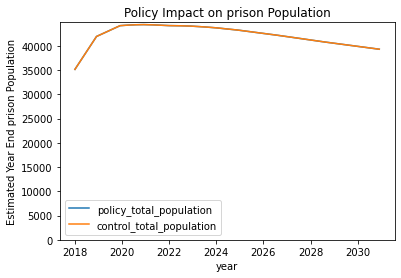

In [3]:
# DISAGGREGATION AXES
race = ['white', 'non-white']
crime_classification = ['murder', 'class_x', 'class_1', 'class_2', 'class_3']

affected_crimes = {
    'murder': 20 * 12, 
    'class_x': 6 * 12, 
    'class_1': 4 * 12, 
    'class_2': 3 * 12, 
    'class_3': 2 * 12, 
}


# Policy Option Methods
def abolish_mm(mm, retroactive=False):
    return partial(IncarceratedTransitions.abolish_mandatory_minimum, 
                   current_mm=mm, 
                   outflow = 'probation',
                   retroactive=retroactive)


policy_list_non_retroactive = list()
policy_list_retroactive = list()

for crime, mm in affected_crimes.items():
    for demo in race:
        policy_list_non_retroactive.append(SparkPolicy(
            policy_fn=abolish_mm(mm),
            spark_compartment='prison',
            sub_population={'crime_classification': crime, 'race': demo},
            apply_retroactive=False
        ))
        policy_list_retroactive.append(SparkPolicy(
            policy_fn=abolish_mm(mm, True),
            spark_compartment='prison',
            sub_population={'crime_classification': crime, 'race': demo},
            apply_retroactive=True
        ))
    
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison')

In [5]:
simulation_tag = 'IL_reduced_mandatory_minimums'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)